#Let's cluster stocks together base on their efficiency on generate profit by using k means


- to find financially similar companies regardless of sector or stock price.

- to identify efficient vs. inefficient companies.

- to compare companies across industries using standardized performance metrics.

- for long-term investors, this might helps in selecting companies with strong fundamentals, not just those trending in price.

Why k mean clustering?

K-Means is chosen for its simplicity, speed, and effectiveness in grouping stocks with similaruty of their features, making it a practical first step for uncovering patterns in financial data.

#Step one: load the dataset
*source of data: TD Ameritrade 2019*

In [208]:
import pandas as pd

stock_df = pd.read_csv('stock_data.csv')

stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5222 entries, 0 to 5221
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   beta                 5222 non-null   float64
 1   bookValuePerShare    5222 non-null   float64
 2   currentRatio         5222 non-null   float64
 3   divGrowthRate3Year   5222 non-null   float64
 4   dividendAmount       5222 non-null   float64
 5   dividendDate         2630 non-null   object 
 6   dividendPayAmount    5222 non-null   float64
 7   dividendPayDate      2630 non-null   object 
 8   dividendYield        5222 non-null   float64
 9   epsChange            5222 non-null   float64
 10  epsChangePercentTTM  5222 non-null   float64
 11  epsChangeYear        5222 non-null   float64
 12  epsTTM               5222 non-null   float64
 13  grossMarginMRQ       5222 non-null   float64
 14  grossMarginTTM       5222 non-null   float64
 15  high52               5222 non-null   f

Let's see some data, so we know what we're dealing with

In [209]:
stock_df.head()

,beta,bookValuePerShare,currentRatio,divGrowthRate3Year,dividendAmount,dividendDate,dividendPayAmount,dividendPayDate,dividendYield,epsChange,...,revChangeYear,sharesOutstanding,shortIntDayToCover,shortIntToFloat,symbol,totalDebtToCapital,totalDebtToEquity,vol10DayAvg,vol1DayAvg,vol3MonthAvg
0,1.21802,2.79895,1.31538,0.0,3.080000,2019-05-10 00:00:00.0,0.770000,2019-08-16 00:00:00.0,1.57,0.0,...,0.0,4601.07500,0.0,0.0,AAPL,51.54927,106.3952,22963900.0,22963900.0,585636010.0
1,2.35784,0.00000,18.20330,0.0,0.000000,NaN,0.000000,NaN,0.00,0.0,...,0.0,63.78077,0.0,0.0,ADVM,0.00000,0.0000,625225.0,625220.0,13701860.0
2,0.85623,31.06079,3.46119,0.0,0.000000,NaN,0.000000,NaN,0.00,0.0,...,0.0,59.12744,0.0,0.0,AAXN,0.00000,0.0000,1287277.0,1287280.0,15188870.0
3,0.66686,0.00000,6.23734,0.0,0.000000,NaN,0.000000,NaN,0.00,0.0,...,0.0,50.06428,0.0,0.0,ACTG,0.00000,0.0000,104801.0,104800.0,2676700.0
4,0.94418,0.00000,0.00000,0.0,1.338665,2019-06-17 00:00:00.0,0.411154,2019-12-23 00:00:00.0,1.95,0.0,...,0.0,58.80000,0.0,0.0,AAXJ,0.00000,0.0000,736602.0,736600.0,29469660.0


#select the features which we will use to cluster the stocks

as mentioned above, we want to group the stocks together using efficiency. So we will be using 3 features from this dataframe
1. ROE (Return on Equity): Measures how effectively a company generates profit from shareholders’ equity.

2. ROA (Return on Assets): Shows how efficiently a company uses its total assets to produce profit.

3. ROI (Return on Investment): Indicates the overall return a company earns on all capital invested, including debt and equity.

PS. if we use more and more attribute it's going to be harder to find pattern in the data and it's going to be harder to group them together because we using k means clustering

So first thing first, let's define our indicator features and store them as a dataframe.

then we check for any missing values and unfortunately we have to drop any rows with missing value because

- The capability of k means clustering:
 because it relies on  Euclidean distance calculations, if there're any missing value, the distance can't be calculate and it breaks the algorithm.
- To preserve data integrity:
While it’s possible to fill in missing values using methods like the mean, median, or forward-fill, doing so in this context can distort the actual behavior of a stock.



In [210]:
metrics_list = ['returnOnEquity','returnOnAssets','returnOnInvestment','symbol']

indicators_df = stock_df[metrics_list]

display(indicators_df.head())

,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
0,48.18294,15.8055,21.30287,AAPL
1,0.00000,0.0000,0.00000,ADVM
2,6.76543,4.0626,5.47783,AAXN
3,0.00000,0.0000,0.00000,ACTG
4,0.00000,0.0000,0.00000,AAXJ


#Step two: let's clean our data

In [211]:
indicators_df = indicators_df[indicators_df[metrics_list] != 0]
indicators_df = indicators_df.dropna(how='any')

display(indicators_df.head())

,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
0,48.18294,15.80550,21.30287,AAPL
2,6.76543,4.06260,5.47783,AAXN
5,45.43475,30.16776,36.04312,ADES
6,12.91672,3.53989,4.31677,ACCO
12,12.08748,4.19331,4.94682,AAWW


let's use the stock symbol as our index to make life easier

and also make sure that everything is a numerical input so our model can work properly

In [212]:
indicators_df = indicators_df.set_index('symbol')

indicators_df = indicators_df.astype('float')

indicators_df.head()

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
AAPL,48.18294,15.80550,21.30287
AAXN,6.76543,4.06260,5.47783
ADES,45.43475,30.16776,36.04312
ACCO,12.91672,3.53989,4.31677
AAWW,12.08748,4.19331,4.94682


then we remove outlier which will 100% affect our model if left uncheck.

***But the important question is How do we define outliers?***

we want to use IQR method because

- Financial ratios like ROE, ROA, and ROI are often not normally distributed — many companies cluster around moderate values, but a few have very high or negative values. IQR focuses on the middle 50% of the data, so it's less affected by extreme outliers than mean+SD.

- Mean and standard deviation assume roughly normal (bell curve) data, which is often violated for financial ratios. IQR works well even for skewed or heavy-tailed distributions.

- Many analysts use IQR-based rules to flag unusually high or low values.

- It sets thresholds based on actual data spread without being distorted by the outliers you want to detect.

we'll use 2 to multiply instead of typical 1.5 because we want to increase the tolerance and prevent the chance of cutting off real impressive performers from our data.

In [213]:
def iqr_upper_threshold(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q3 + 2 * iqr

roe_threshold = iqr_upper_threshold(indicators_df['returnOnEquity'])
roa_threshold = iqr_upper_threshold(indicators_df['returnOnAssets'])
roi_threshold = iqr_upper_threshold(indicators_df['returnOnInvestment'])

print(f"ROE IQR-based upper threshold: {roe_threshold:.2f}")
print(f"ROA IQR-based upper threshold: {roa_threshold:.2f}")
print(f"ROI IQR-based upper threshold: {roi_threshold:.2f}")


ROE IQR-based upper threshold: 50.61
ROA IQR-based upper threshold: 22.77
ROI IQR-based upper threshold: 29.44


After we have our threshole for each features, let's check how many outliers we have base on our thresholds.

In [214]:
# define the filters
roe_filter = indicators_df.iloc[:,0] < roe_threshold
roa_filter = indicators_df.iloc[:,1] < roa_threshold
roi_filter = indicators_df.iloc[:,2] < roi_threshold

# get the counts for each column
roe_count = pd.Series(roe_filter).value_counts()
roa_count = pd.Series(roa_filter).value_counts()
roi_count = pd.Series(roi_filter).value_counts()

display(roe_count)
display(roa_count)
display(roi_count)

,count
returnOnEquity,
True,1964
False,138


,count
returnOnAssets,
True,2026
False,76


,count
returnOnInvestment,
True,2018
False,84


We've flagged 138, 76, 84 outliers using the IQR method, which is a small portion of the data and shouldn’t affect the overall analysis. If the number had been much higher, we would’ve considered adjusting the threshold to avoid losing too much valuable information.

So let's go ahead and drop them

In [215]:
indicators_df = indicators_df[roe_filter & roa_filter & roi_filter]

And we're done cleaning our data, let's see some stats of our data

In [216]:
desc_df = indicators_df.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

desc_df

,returnOnEquity,returnOnAssets,returnOnInvestment
count,1919.000000,1919.000000,1919.000000
mean,13.190603,6.015927,7.691950
std,9.724722,4.521981,5.856088
min,0.044180,0.036950,0.041490
25%,5.857620,2.602180,3.190235
50%,11.228950,4.836290,6.258210
75%,18.126015,8.330385,10.722945
max,49.921310,22.742740,29.104920
+3_std,42.364771,19.581871,25.260212
-3_std,-15.983564,-7.550017,-9.876313


Let's visualize our data to see how it distribute and because we use 3 features so we plot it in 3D chart

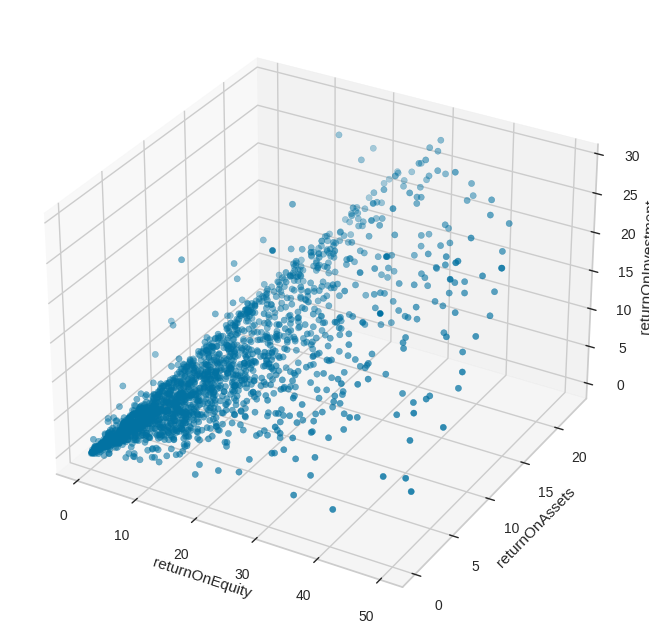

In [217]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = list(indicators_df.iloc[:,0])
y = list(indicators_df.iloc[:,1])
z = list(indicators_df.iloc[:,2])

column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

ax.scatter(x, y, z, marker='o')

plt.show()

In hope for better performance model :D, we normalize the data to ensure that each metric contributes equally to the analysis, especially for our distance-based clustering

Why?
- ROE, ROA, and ROI may be on different scales (e.g., ROE could range from -100% to 80%, while ROA and ROI might be much smaller).

- Without normalization, larger-scale features dominate, making the model biased.

- Normalization makes the data comparable, improving the accuracy and fairness of the results.

we have 3 basic options to choose from

- StandardScaler: Scales data to have zero mean and unit variance (normal distribution).

- MinMaxScaler: Scales data to a [0, 1] range, preserving the shape but shrinking the scale.

- RobustScaler: Scales using the median and IQR, making it resistant to outliers.

We chose RobustScaler because financial ratios like ROE, ROA, and ROI are often skewed and contain outliers. RobustScaler minimizes the impact of these extreme values, allowing us to normalize the data without distorting the overall distribution, which helps improve the accuracy of clustering or other downstream analyses.





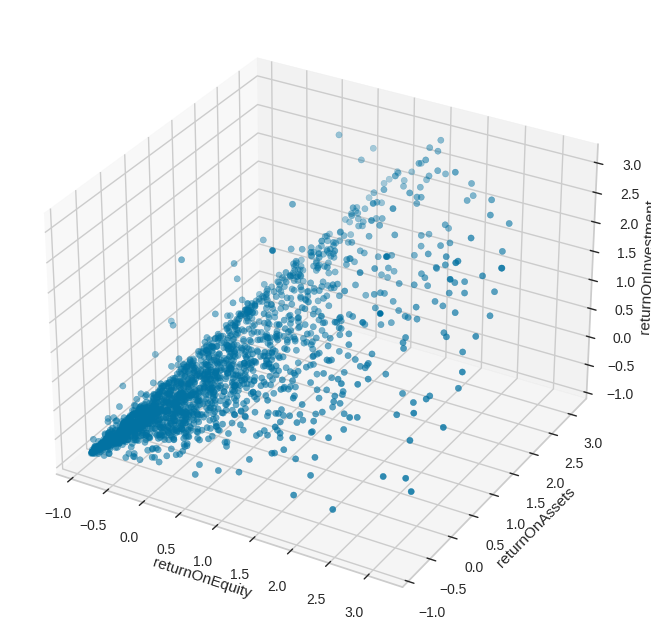

In [218]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

X_train_minmax = min_max_scaler.fit_transform(indicators_df)
X_train_standard = std_scaler.fit_transform(indicators_df)
X_train_robust = robust_scaler.fit_transform(indicators_df)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = X_train_robust[:,0]
y = X_train_robust[:,1]
z = X_train_robust[:,2]

column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

ax.scatter(x, y, z)

plt.show()

our plotted data might appear to be the same but the scale is now much smaller and each features are now normalized

#Setp three: PCA

Let's reduce our features in to 2 dimensions (even we only use 3 features to begin with) but still capture the essence of 3 features.

Because we want to:
- Simplifies the data and enables 2D visualization

- Handles multicollinearity
ROE, ROA, and ROI are often correlated, measuring profitability in different ways. PCA transforms them into uncorrelated components, which helps avoid redundancy and improves clustering accuracy.

- Improves clustering performance
By removing noise and compressing the data into fewer dimensions, PCA makes clustering more effective and less sensitive to irrelevant variation.




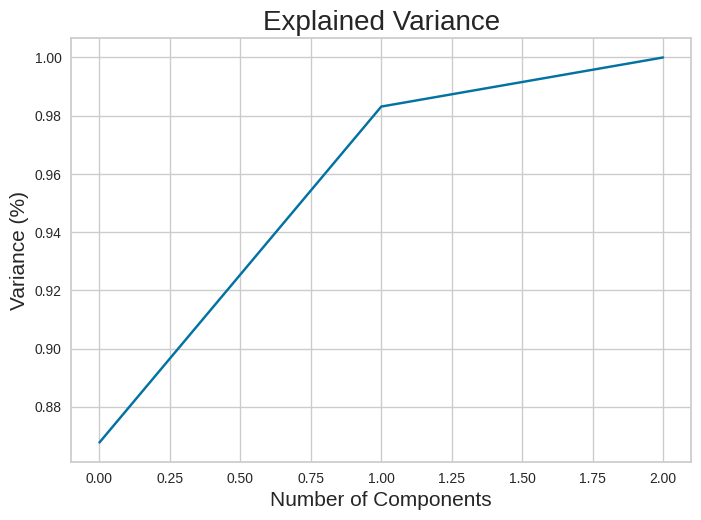

In [219]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_robust)

# plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15)
plt.title('Explained Variance', fontsize = 20)

plt.show()

As we can see, we can capture 100% of variance explaination by using just 2 principle components instead of using 3 features

we can now go ahead and create a new PCA data frame

In [220]:
pca_dataset = PCA(n_components=2).fit(X_train_robust).transform(X_train_robust)

# store it in a new data frame
pca_dataset= pd.DataFrame(data = pca_dataset, columns = ['principal component 1', 'principal component 2'])
pca_dataset.head()

,principal component 1,principal component 2
0,3.639506,1.036204
1,-0.661951,-0.189820
2,-0.533909,0.318175
3,-0.453608,0.183792
4,-0.414933,-0.282881


Now we see what our data looks like in 2D space

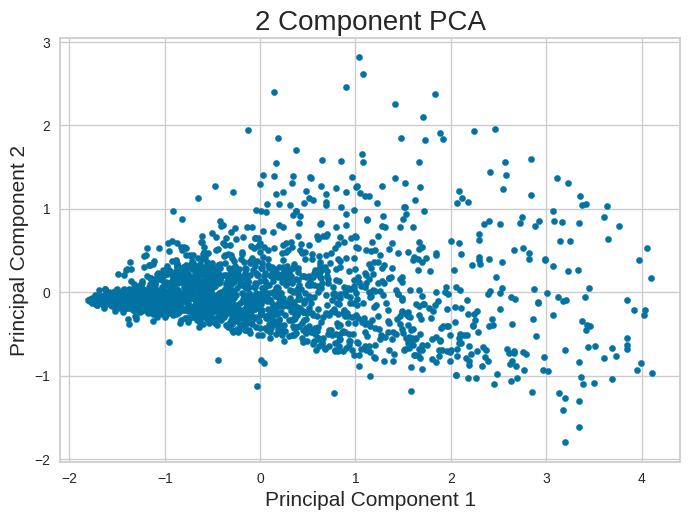

In [221]:
plt.figure()

plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA', fontsize = 20)

plt.scatter(pca_dataset['principal component 1'], pca_dataset['principal component 2'], s = 20)

#Step four: build a model

first we want to know "How many cluster should we divide stocks into?" we evaluate this by using silhouette score.
we evaluate between 2-10 cluster to see which one will give us the best performance.

Silhouette Score: how well the cluster are seperated range from 0-1, the closer to 1 means the clusters are well seperated, closer to 0 means the clusters are overlapped

we will also find the inertia of each number of cluster to see how tight our cluster are. The less number of cluster will of cause have bigger inertia

first let use our data that we scaled it with robust scaler

In [222]:
from sklearn.cluster import KMeans
from sklearn import metrics

# define a dictionary that contains all of our relevant info.
results_dict = {}

num_of_clusters = 11

for k in range(2, num_of_clusters):

    print("-"*100)

    # define the next dictionary to hold all the results of this run.
    results_dict[k] = {}

    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train_robust)

    # define the silhouette score
    sil_score = metrics.silhouette_score(X_train_robust, kmeans.labels_, metric='euclidean')

    # store the different metrics
    results_dict[k]['silhouette_score'] = sil_score
    results_dict[k]['inertia'] = kmeans.inertia_
    results_dict[k]['model'] = kmeans

    # print the results
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)
    print('Inertia:', kmeans.inertia_)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5443356800421514
Inertia: 1445.4932402191616
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.463948507667864
Inertia: 921.0420586829349
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.44314459731126754
Inertia: 751.4443965209597
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.4169663356944923
Inertia: 585.7670906867369
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.40910942919703996
Inertia: 517.7653551218824
---------------------------------------------------------------

Here are the results of clustering with different numbers of clusters (2 to 10). We look at two key metrics:

Inertia: Measures how tightly grouped the clusters are (lower is better).

Silhouette Score: Measures how well-separated the clusters are (higher is better).

As expected, inertia decreases as we add more clusters. Now, let’s plot inertia to visually find the “elbow” where the inertia stops decreasing sharply and starts leveling off.

it suggests the best balance between having tight clusters and not too many clusters.



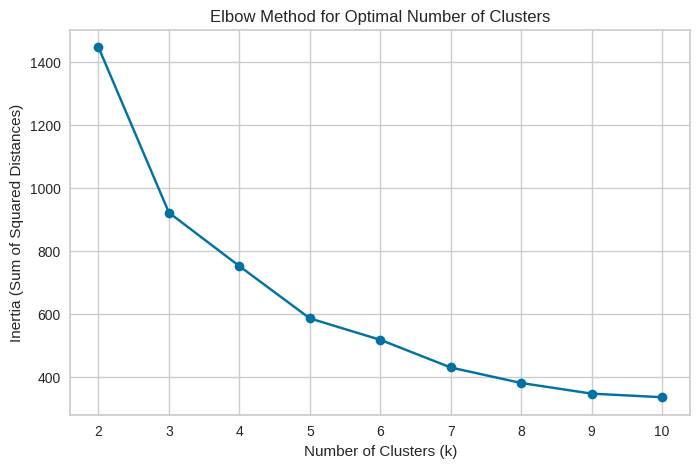

In [223]:
# Extract the number of clusters and their corresponding inertia values
cluster_counts = list(results_dict.keys())
inertia_values = [results_dict[k]['inertia'] for k in cluster_counts]

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_counts, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_counts)
plt.grid(True)
plt.show()


From this plot, inertia decreases sharply from 2 to 3 clusters and keeps decreasing but with diminishing returns.

The “elbow” in inertia is likely around 3 or 4 clusters, where the drop in inertia slows down.

let's run it again but this time with our pca dataset

In [224]:
results_dict_pca = {}

num_of_clusters = 11


for k in range(2, num_of_clusters):

    print("-"*100)

    results_dict_pca[k] = {}

    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_dataset)

    sil_score = metrics.silhouette_score(pca_dataset, kmeans.labels_, metric='euclidean')

    results_dict_pca[k]['silhouette_score'] = sil_score
    results_dict[k]['inertia'] = kmeans.inertia_
    results_dict_pca[k]['model'] = kmeans

    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)
    print('Inertia:', kmeans.inertia_)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5525378943745937
Inertia: 1385.470128592366
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.476889690620162
Inertia: 861.1404582240265
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.4144470355007203
Inertia: 672.2794888811733
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.4269328147150847
Inertia: 525.2514741821259
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.4224284714264008
Inertia: 453.6923175082509
------------------------------------------------------------------

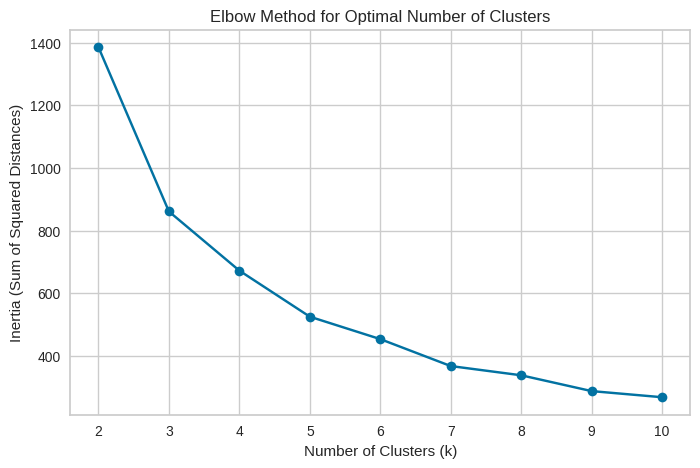

In [225]:
cluster_counts = list(results_dict.keys())
inertia_values = [results_dict[k]['inertia'] for k in cluster_counts]

plt.figure(figsize=(8, 5))
plt.plot(cluster_counts, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_counts)
plt.grid(True)
plt.show()


with both robust scaled data and pca we can conclude that

2 clusters offer the best in term of cluster separation (highest silhouette score)

3 clusters balancing a good silhouette score and a big drop in inertia and also might be better in term of deeper insight for the context of our data (distinguish high performer)

but from now on let do both version 2 and 3 clusters

#Step five: evaluate model

we'll evaluate model with silhouette visualizer to see the quality of the cluster with our data

we'll be comparing 2 and 3 clustering with both robust scaled data and pca data

starting with robust scaled data

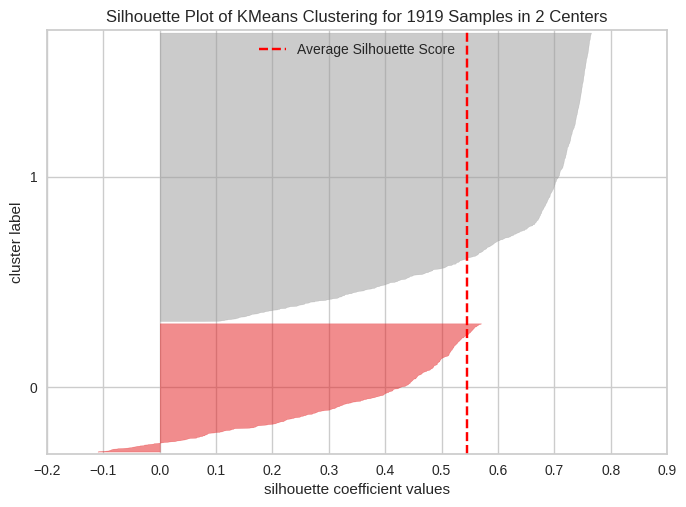

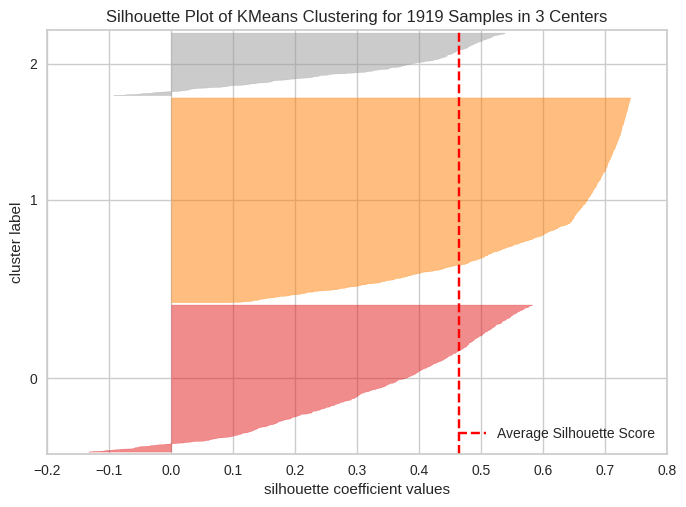

In [226]:
from yellowbrick.cluster import SilhouetteVisualizer

clusters = [2,3]

for cluster in clusters:

    # define the model for K
    kmeans = KMeans(n_clusters = cluster, random_state=0)

    visualizer = SilhouetteVisualizer(kmeans)

    visualizer.fit(X_train_robust)

    visualizer.poof()

from the silhouette visualization

2 clusters: the average silhouette score is 0.54 which is quite decent
- the population in each cluster is fairly balanced
- only few negative silhouette in cluster 0


3 clusters: the average silhouette score is 0.46 which is lower than the 2 clusters model meaning that the cluster quality decline slightly

- all three clusters are reasonably populated
- the cluster 2 has more samples with low or negative silhouette values. some samples in this cluster may be poorly assigned.

Verdict:
- 3 clusters offer better business insight, even with a slightly lower silhouette score.

- The third cluster enables us to isolate a distinct segment of high-performing companies, which is valuable for targeted investment strategies (e.g., aggressive growth portfolios).

- The drop in silhouette score is an acceptable trade-off for more granular segmentation and actionable differentiation.



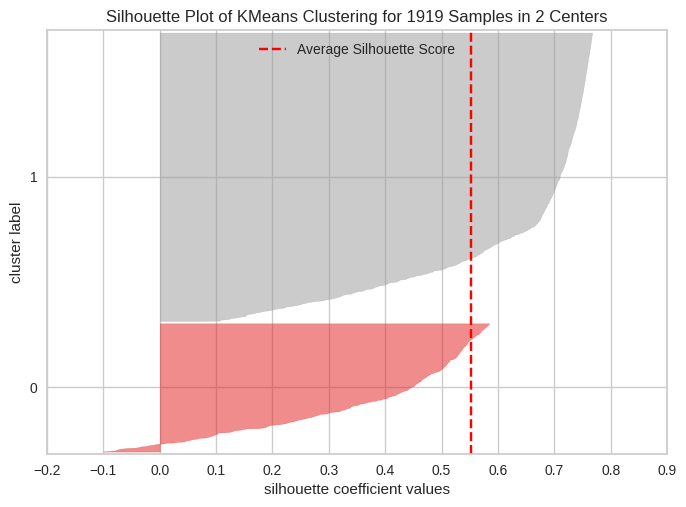

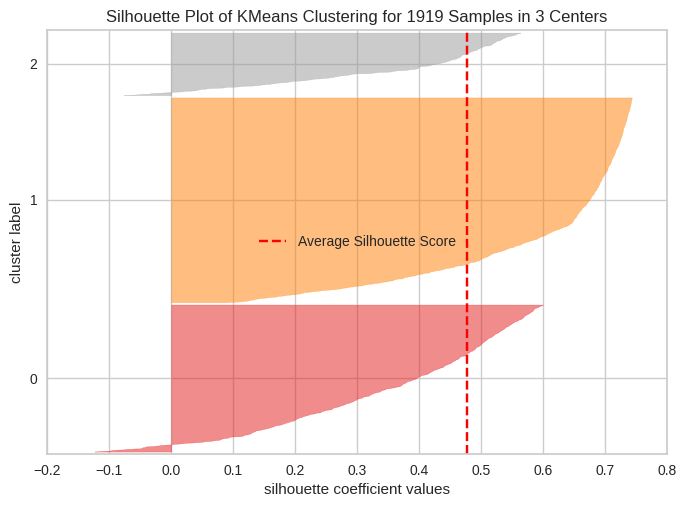

In [227]:
clusters = [2,3]

for cluster in clusters:

    kmeans = KMeans(n_clusters = cluster, random_state=0)

    visualizer = SilhouetteVisualizer(kmeans)

    visualizer.fit(pca_dataset)

    visualizer.poof()

the chart appeared to have the same characteristic as the one from robust scaled data. and we are satisfied with our model with 2 and 3 clusters both have decent silhouette score and only few negative points this imply that our clusters are meaningful

But if the average silhouette score is less than 0.25 we might consider trying another algorithm (e.g., DBSCAN, Agglomerative Clustering).

#Step six: chart the cluster

Finally let's see what our clusters look like in both 3D and 2D space

starting with robust scaled data as usual

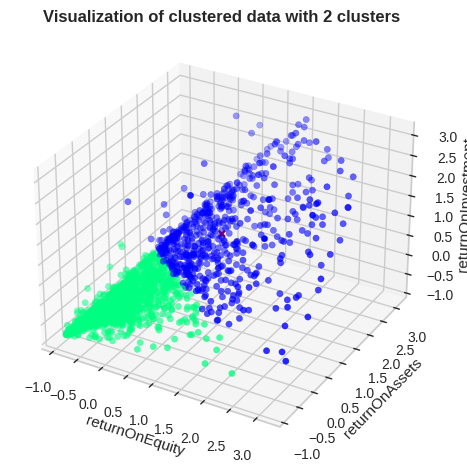

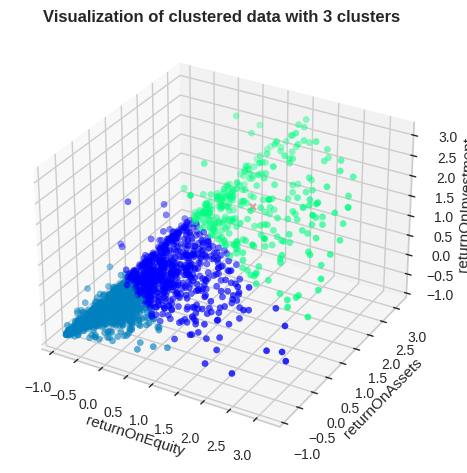

In [228]:
clusters = [2,3]

for cluster in clusters:

    kmeans = KMeans(n_clusters= cluster, random_state=0).fit(X_train_robust)

    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    column_names = indicators_df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

2 Clusters
- Clear separation into two groups along the ROI, ROE, and ROA axes.
- Compact clusters, especially for high-return entities.

3 Clusters
- One cluster (the teal group) splits off from the original green group.
- The new division may not provide strong added value — centroids are closer.
- Slight overlap suggests weaker segmentation clarity.

Conclusion
- **2 clusters** offer clearer segmentation with better interpretability.
- Clusters likely distinguish between **high-performance vs. moderate/low-performance** entities.

PS. the X marks for centriods are in there but not visible due to data points that are plotted on top on them

followed by pca dataset

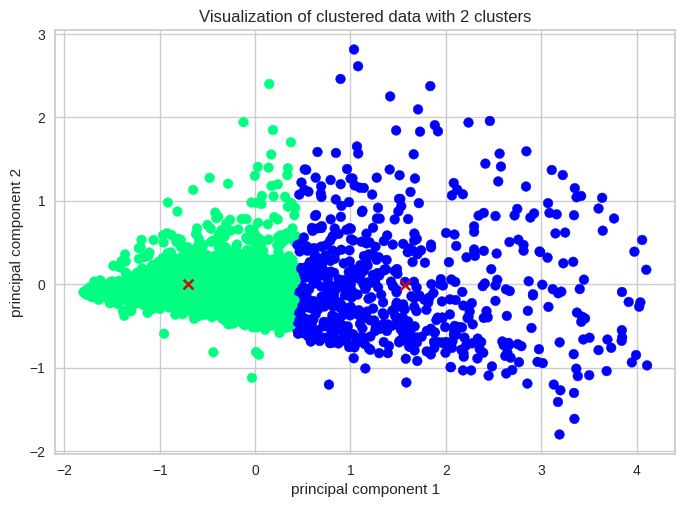

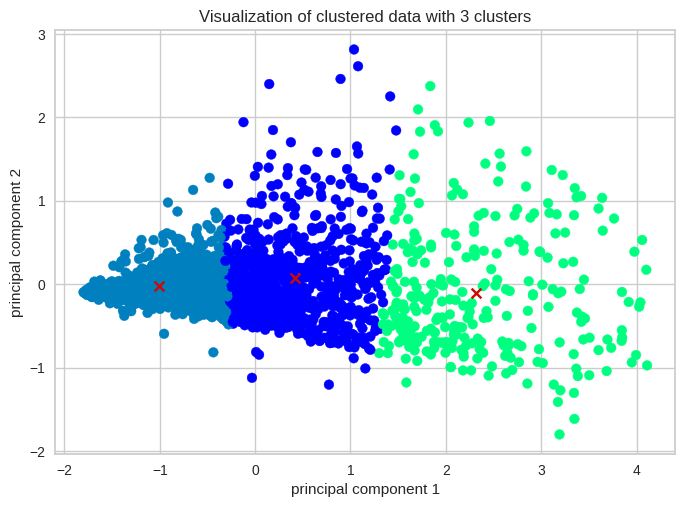

In [229]:
clusters = [2,3]

for cluster in clusters:

    kmeans = KMeans(n_clusters= cluster, random_state=0).fit(pca_dataset)

    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]

    plt.figure()

    x = pca_dataset['principal component 1']
    y = pca_dataset['principal component 2']


    column_names = pca_dataset.columns
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])

    plt.scatter(x, y, c=kmeans.labels_.astype(float), cmap='winter')
    plt.scatter(C1, C2, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster))
    plt.show()

- **Red X marks** show the **cluster centroids**.
- **2 clusters**: Clearly separated groups with compact shapes.
- **3 clusters**: One original group is split into two, with centroids closer together -> weaker separation.

Conclusion
- **2 clusters** is better in term of cluster quality
  - Simpler, cleaner grouping.
  - Stronger separation.
  - Aligns with both silhouette score and visual clarity.
- **3 clusters** offer better business insight, even with a slightly lower silhouette score.
  - model provides more interpretability and practical value, especially for identifying a top-performing group that would otherwise be diluted.


 The clustering model successfully grouped companies into 2 and 3 distinct clusters. Each cluster displayed different levels of ROE, ROA, and ROI:

 2 clusters:
  - cluster 0 -> companies with lower level of profit generating efficiency
  - cluster 1 -> companies with higher level of profit generating efficiency

3 clusters:
  - cluster 0 -> companies with lower level of profit generating efficiency
  - cluster 1 -> companies with mid level of profit generating efficiency
  - cluster 2 -> companies with higher level of profit generating efficiency


#Step seven: make prediction

we can now enjoy the fruit of our labor

we can now pick a stock that we're intered in scale its ROE, ROA, ROI with robust scaler then feed it to the model.

Let's mock up 2 stocks and put them into our clusters

In [243]:
kmeans = results_dict[3]['model']

test_data = [[1.3, 1.1, 1.2],
             [0.6, 1.2, 0.8]]

kmeans.predict(test_data)

array([2, 0], dtype=int32)

SO the stock from the first company is assigned to cluster 2 (high performer) while the second company is assigned to cluster 0 (low performer)

**Real-World Use Case**: Screening Undervalued Stocks in Emerging Markets
An investment firm wants to identify financially strong but under-the-radar companies in emerging markets, where data is often incomplete and industry classifications are inconsistent.

They can apply this K-Means clustering model, trained on ROE, ROA, and ROI, across all listed companies in the region—regardless of sector. The goal is to group companies by financial efficiency, not by industry.

One cluster reveals a group of high-ROE, high-ROI firms with low analyst coverage and low market cap. These companies—mostly small manufacturers and logistics firms—are not obvious picks in traditional screens.

Analysts can investigate further and find several promising investment opportunities. These companies are added to a specialized fund focused on emerging market value plays.

Key Value:
Helps uncover hidden, high-performing companies that don’t surface in standard filters

Bypasses noisy or unreliable industry classifications

Supports scalable, data-driven screening before deeper analysis


--------------------------------------------------------------------------------
While this K-Means model clusters stocks using ROE, ROA, and ROI, it does not account for industry context. As a result, some clusters may group together companies with fundamentally different business models and risk profiles.

However, this model provides a useful first-pass tool for identifying broad financial patterns. It can be refined in the future by:

- Incorporating industry segmentation

- Including additional financial or market features

- Applying domain-specific clustering strategies

Ultimately, this demonstrates how unsupervised learning can uncover hidden structure in financial data — but also the importance of domain knowledge in interpreting the results.